In [78]:
import pandas as pd
from mlrun import MLClientCtx
import os
import mlrun.feature_store as fs
import mlrun
import numpy as np
import yfinance as yf
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from datetime import datetime
import keras
import nuclio

In [115]:
tickers = ['GOOGL','MSFT','AMZN','AAPL','INTC']
df = pd.DataFrame()
for ticker in tickers:
    hist = yf.Ticker(ticker).history(period="6mo", interval='1h')
    hist["Symbol"] = ticker
    df = df.append(hist)
df["Sentiment"] = np.random.uniform(-1,1,df.shape[0])
df = df.reset_index(drop = False)
df = df.drop(["Dividends","Stock Splits"],axis = 1)

In [116]:
df

,Date,Open,High,Low,Close,Volume,Symbol,Sentiment
0,2020-10-29,1517.020020,1550.709961,1516.550049,1548.540039,0,GOOGL,-0.278520
1,2020-10-29,1549.619995,1556.030029,1542.064941,1554.994995,163062,GOOGL,0.209931
2,2020-10-29,1554.509888,1557.640015,1546.750000,1554.780029,144783,GOOGL,0.653395
3,2020-10-29,1555.699951,1565.685303,1554.239990,1565.685303,138878,GOOGL,0.478146
4,2020-10-29,1566.349976,1588.685059,1563.790039,1587.963379,276671,GOOGL,0.930124
...,...,...,...,...,...,...,...,...
4315,2021-04-28,57.610001,57.639999,57.360001,57.570000,2554605,INTC,0.191751
4316,2021-04-28,57.575001,57.849998,57.490002,57.610001,3038906,INTC,-0.965739
4317,2021-04-28,57.610001,57.759998,57.529999,57.610001,3118910,INTC,0.448572
4318,2021-04-29,57.880001,58.240002,57.865002,57.994999,2577038,INTC,0.627608


In [79]:
mlrun.set_environment(project = "stocks-dani")

('stocks-dani', 'v3io:///projects/{{run.project}}/artifacts')

In [74]:
%nuclio env -c V3IO_ACCESS_KEY=${V3IO_ACCESS_KEY}
%nuclio env -c V3IO_USERNAME=${V3IO_USERNAME}
%nuclio env -c V3IO_API=${V3IO_API}

In [81]:
stocks_set = fs.FeatureSet("stocks-testdani", entities=[fs.Entity("Symbol")],timestamp_key="Date")
stocks_set.set_targets()

# Adding aggregations
stocks_set.add_aggregation("Closes","Close",["min","max"],["1d"],"30m")
stocks_set.add_aggregation("Opens","Open",["min","max"],["1d"],"30m")
stocks_set.add_aggregation("Volumes","Volume",["min","max"],["1h"],"30m")
stocks_set.add_aggregation("Sentiments","Sentiment",["min","max"],["1d"],"30m")

In [82]:
fs.ingest(stocks_set,df)

,Closes_max_1d,Closes_min_1d,Opens_max_1d,Opens_min_1d,Volumes_max_1h,Volumes_min_1h,Sentiments_max_1d,Sentiments_min_1d,Date,Open,High,Low,Close,Volume,Sentiment
Symbol,,,,,,,,,,,,,,,
GOOGL,1548.540039,1548.540039,1517.020020,1517.020020,416755,416755,-0.267899,-0.267899,2020-10-29,1517.020020,1550.709961,1516.550049,1548.540039,416755,-0.267899
GOOGL,1554.994995,1548.540039,1549.619995,1517.020020,416755,163062,0.787885,-0.267899,2020-10-29,1549.619995,1556.030029,1542.064941,1554.994995,163062,0.787885
GOOGL,1554.994995,1548.540039,1554.509888,1517.020020,416755,144783,0.787885,-0.346130,2020-10-29,1554.509888,1557.640015,1546.750000,1554.780029,144783,-0.346130
GOOGL,1565.685303,1548.540039,1555.699951,1517.020020,416755,138878,0.787885,-0.346130,2020-10-29,1555.699951,1565.685303,1554.239990,1565.685303,138878,-0.097657
GOOGL,1587.963379,1548.540039,1566.349976,1517.020020,416755,138878,0.787885,-0.346130,2020-10-29,1566.349976,1588.685059,1563.790039,1587.963379,276671,0.299191
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
INTC,57.700001,57.334999,57.705002,57.334999,7287213,2633694,0.145518,-0.111467,2021-04-28,57.334999,57.480000,57.230000,57.459999,2633694,0.125860
INTC,57.700001,57.334999,57.705002,57.334999,7287213,2090140,0.145518,-0.410191,2021-04-28,57.454498,57.630001,57.430000,57.618500,2090140,-0.410191
INTC,57.700001,57.334999,57.705002,57.334999,7287213,2090140,0.145518,-0.441061,2021-04-28,57.610001,57.639999,57.360001,57.570000,2554605,-0.441061


In [84]:
features = ["stocks-dani.*"]

# Making our vector
vector = fs.FeatureVector("stocks-vecdani", features, description="stocks demo feature vector")
vector.save()

In [87]:
offline_data = fs.get_offline_features("stocks-vecdani").to_dataframe().reset_index(drop = False)

In [88]:
offline_data

,Symbol,Closes_min_1d,Closes_max_1d,Opens_min_1d,Opens_max_1d,Volumes_min_1h,Volumes_max_1h,Sentiments_min_1d,Sentiments_max_1d,Open,High,Low,Close,Volume,Sentiment
0,GOOGL,1548.540039,1548.540039,1517.020020,1517.020020,416755,416755,-0.267899,-0.267899,1517.020020,1550.709961,1516.550049,1548.540039,416755,-0.267899
1,GOOGL,1548.540039,1554.994995,1517.020020,1549.619995,163062,416755,-0.267899,0.787885,1549.619995,1556.030029,1542.064941,1554.994995,163062,0.787885
2,GOOGL,1548.540039,1554.994995,1517.020020,1554.509888,144783,416755,-0.346130,0.787885,1554.509888,1557.640015,1546.750000,1554.780029,144783,-0.346130
3,GOOGL,1548.540039,1565.685303,1517.020020,1555.699951,138878,416755,-0.346130,0.787885,1555.699951,1565.685303,1554.239990,1565.685303,138878,-0.097657
4,GOOGL,1548.540039,1587.963379,1517.020020,1566.349976,138878,416755,-0.346130,0.787885,1566.349976,1588.685059,1563.790039,1587.963379,276671,0.299191
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4305,INTC,57.334999,57.700001,57.334999,57.705002,2633694,7287213,-0.111467,0.145518,57.334999,57.480000,57.230000,57.459999,2633694,0.125860
4306,INTC,57.334999,57.700001,57.334999,57.705002,2090140,7287213,-0.410191,0.145518,57.454498,57.630001,57.430000,57.618500,2090140,-0.410191
4307,INTC,57.334999,57.700001,57.334999,57.705002,2090140,7287213,-0.441061,0.145518,57.610001,57.639999,57.360001,57.570000,2554605,-0.441061
4308,INTC,57.334999,57.700001,57.334999,57.705002,2090140,7287213,-0.747003,0.145518,57.575001,57.849998,57.490002,57.610001,3038906,-0.747003


In [90]:
ticker_to_int = {'GOOGL' : 0,'MSFT' : 1,'AMZN' : 2,'AAPL' : 3,'INTC' : 4}
offline_data["Symbol"] = offline_data["Symbol"].apply(lambda x: ticker_to_int.get(x))
offline_data

,Symbol,Closes_min_1d,Closes_max_1d,Opens_min_1d,Opens_max_1d,Volumes_min_1h,Volumes_max_1h,Sentiments_min_1d,Sentiments_max_1d,Open,High,Low,Close,Volume,Sentiment
0,0,1548.540039,1548.540039,1517.020020,1517.020020,416755,416755,-0.267899,-0.267899,1517.020020,1550.709961,1516.550049,1548.540039,416755,-0.267899
1,0,1548.540039,1554.994995,1517.020020,1549.619995,163062,416755,-0.267899,0.787885,1549.619995,1556.030029,1542.064941,1554.994995,163062,0.787885
2,0,1548.540039,1554.994995,1517.020020,1554.509888,144783,416755,-0.346130,0.787885,1554.509888,1557.640015,1546.750000,1554.780029,144783,-0.346130
3,0,1548.540039,1565.685303,1517.020020,1555.699951,138878,416755,-0.346130,0.787885,1555.699951,1565.685303,1554.239990,1565.685303,138878,-0.097657
4,0,1548.540039,1587.963379,1517.020020,1566.349976,138878,416755,-0.346130,0.787885,1566.349976,1588.685059,1563.790039,1587.963379,276671,0.299191
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4305,4,57.334999,57.700001,57.334999,57.705002,2633694,7287213,-0.111467,0.145518,57.334999,57.480000,57.230000,57.459999,2633694,0.125860
4306,4,57.334999,57.700001,57.334999,57.705002,2090140,7287213,-0.410191,0.145518,57.454498,57.630001,57.430000,57.618500,2090140,-0.410191
4307,4,57.334999,57.700001,57.334999,57.705002,2090140,7287213,-0.441061,0.145518,57.610001,57.639999,57.360001,57.570000,2554605,-0.441061
4308,4,57.334999,57.700001,57.334999,57.705002,2090140,7287213,-0.747003,0.145518,57.575001,57.849998,57.490002,57.610001,3038906,-0.747003


In [91]:
offline_data.columns

Index(['Symbol', 'Closes_min_1d', 'Closes_max_1d', 'Opens_min_1d',
       'Opens_max_1d', 'Volumes_min_1h', 'Volumes_max_1h', 'Sentiments_min_1d',
       'Sentiments_max_1d', 'Open', 'High', 'Low', 'Close', 'Volume',
       'Sentiment'],
      dtype='object')

In [93]:
print(['Symbol', 'Closes_min_1d', 'Closes_max_1d', 'Opens_min_1d',
       'Opens_max_1d', 'Volumes_min_1h', 'Volumes_max_1h', 'Sentiments_min_1d',
       'Sentiments_max_1d', 'Open', 'High', 'Low', 'Close', 'Volume',
       'Sentiment'])

['Symbol', 'Closes_min_1d', 'Closes_max_1d', 'Opens_min_1d', 'Opens_max_1d', 'Volumes_min_1h', 'Volumes_max_1h', 'Sentiments_min_1d', 'Sentiments_max_1d', 'Open', 'High', 'Low', 'Close', 'Volume', 'Sentiment']


In [117]:
def modify_data(stk_data,price_sc = None,volume_sc = None,sentiment_sc = None):
    if(not(price_sc)):
        price_sc = MinMaxScaler(feature_range = (0, 1))
    if(not(volume_sc)):
        volume_sc = MinMaxScaler(feature_range = (0, 1))
    if(not(sentiment_sc)):
        sentiment_sc = MinMaxScaler(feature_range = (0, 1))
    
    stk_data = pd.DataFrame(data = stk_data, columns = ['Symbol', 'Closes_min_1d', 'Closes_max_1d', 'Opens_min_1d', 'Opens_max_1d', 'Volumes_min_1h', 'Volumes_max_1h', 'Sentiments_min_1d', 'Sentiments_max_1d', 'Open', 'High', 'Low', 'Close', 'Volume', 'Sentiment'])
    price_columns = ['Closes_min_1d', 'Closes_max_1d', 'Opens_min_1d', 'Opens_max_1d','Open', 'High', 'Low', 'Close']
    for col in price_columns:
        stk_data[[col]] = price_sc.fit_transform(stk_data[[col]])
    
    volume_columns = ['Volumes_min_1h', 'Volumes_max_1h','Volume']
    for col in volume_columns:
        stk_data[[col]] = volume_sc.fit_transform(stk_data[[col]])
    
    sentiment_columns = ['Sentiments_min_1d', 'Sentiments_max_1d',"Sentiment"]
    for col in sentiment_columns:
        stk_data[[col]] = sentiment_sc.fit_transform(stk_data[[col]])
        
    X_train = []
    y_train = []
    size_of_stamps = 10
    data = stk_data.values
    closing = stk_data["Close"].values
    for i in range(size_of_stamps, data.shape[0]):
        X_train.append(data[i-size_of_stamps:i])
        y_train.append(closing[i])
    
    X_train, y_train = np.array(X_train), np.array(y_train)
    X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], stk_data.shape[1]))
    return X_train,y_train,price_sc,volume_sc,sentiment_sc

In [95]:
df = offline_data
df

,Symbol,Closes_min_1d,Closes_max_1d,Opens_min_1d,Opens_max_1d,Volumes_min_1h,Volumes_max_1h,Sentiments_min_1d,Sentiments_max_1d,Open,High,Low,Close,Volume,Sentiment
0,0,1548.540039,1548.540039,1517.020020,1517.020020,416755,416755,-0.267899,-0.267899,1517.020020,1550.709961,1516.550049,1548.540039,416755,-0.267899
1,0,1548.540039,1554.994995,1517.020020,1549.619995,163062,416755,-0.267899,0.787885,1549.619995,1556.030029,1542.064941,1554.994995,163062,0.787885
2,0,1548.540039,1554.994995,1517.020020,1554.509888,144783,416755,-0.346130,0.787885,1554.509888,1557.640015,1546.750000,1554.780029,144783,-0.346130
3,0,1548.540039,1565.685303,1517.020020,1555.699951,138878,416755,-0.346130,0.787885,1555.699951,1565.685303,1554.239990,1565.685303,138878,-0.097657
4,0,1548.540039,1587.963379,1517.020020,1566.349976,138878,416755,-0.346130,0.787885,1566.349976,1588.685059,1563.790039,1587.963379,276671,0.299191
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4305,4,57.334999,57.700001,57.334999,57.705002,2633694,7287213,-0.111467,0.145518,57.334999,57.480000,57.230000,57.459999,2633694,0.125860
4306,4,57.334999,57.700001,57.334999,57.705002,2090140,7287213,-0.410191,0.145518,57.454498,57.630001,57.430000,57.618500,2090140,-0.410191
4307,4,57.334999,57.700001,57.334999,57.705002,2090140,7287213,-0.441061,0.145518,57.610001,57.639999,57.360001,57.570000,2554605,-0.441061
4308,4,57.334999,57.700001,57.334999,57.705002,2090140,7287213,-0.747003,0.145518,57.575001,57.849998,57.490002,57.610001,3038906,-0.747003


In [100]:
x_train_set = []
y_train_set = []
x_test_set = []
y_test_set = []
price_sc,volume_sc,sentiment_sc = None,None,None
for i in range(5):
    ticker_data = df[df["Symbol"] == i]
    ticker_train = ticker_data[:-40]
    ticker_test = ticker_data[-40:]
    if(not(price_sc)):
        X_train,y_train,price_sc,volume_sc,sentiment_sc = modify_data(ticker_train.copy().values)
    else:
        X_train,y_train,price_sc,volume_sc,sentiment_sc = modify_data(ticker_train.copy().values,price_sc,volume_sc,sentiment_sc)
    x_train_set.append(X_train)
    y_train_set.append(y_train)
    
    X_test,y_test,price_sc,volume_sc,sentiment_sc = modify_data(ticker_test.copy().values,price_sc,volume_sc,sentiment_sc)
    x_test_set.append(X_test)
    y_test_set.append(y_test)

In [101]:
final_x_train_set = []
final_y_train_set = []
for i in range(len(x_train_set[0])):
    final_x_train_set.extend([x_train_set[0][i],x_train_set[1][i],x_train_set[2][i],x_train_set[3][i],x_train_set[4][i]])
    final_y_train_set.extend([y_train_set[0][i],y_train_set[1][i],y_train_set[2][i],y_train_set[3][i],y_train_set[4][i]])

final_x_train_set = np.array(final_x_train_set)
final_y_train_set = np.array(final_y_train_set)

In [102]:
regressor = Sequential()
regressor.add(LSTM(units = 50, return_sequences = True, input_shape = (X_train.shape[1], X_train.shape[2])))
regressor.add(Dropout(0.2))
regressor.add(LSTM(units = 50, return_sequences = True))
regressor.add(Dropout(0.2))
regressor.add(LSTM(units = 50, return_sequences = True))
regressor.add(Dropout(0.2))
regressor.add(LSTM(units = 50))
regressor.add(Dropout(0.2))
regressor.add(Dense(units =  1))

#Compiling and fitting the model
regressor.compile(optimizer = 'adam', loss = 'mean_squared_error')
# regressor.fit(X_train, y_train, epochs = 2, batch_size = 32)

In [103]:
regressor.fit(final_x_train_set, final_y_train_set, epochs = 20, batch_size = 32)

Epoch 1/20
127/127 [==============================] - 5s 39ms/step - loss: 0.0223
Epoch 2/20
127/127 [==============================] - 6s 49ms/step - loss: 0.0075
Epoch 3/20
127/127 [==============================] - 7s 55ms/step - loss: 0.0072
Epoch 4/20
127/127 [==============================] - 5s 42ms/step - loss: 0.0065
Epoch 5/20
127/127 [==============================] - 6s 48ms/step - loss: 0.0061
Epoch 6/20
127/127 [==============================] - 6s 47ms/step - loss: 0.0054
Epoch 7/20
127/127 [==============================] - 6s 51ms/step - loss: 0.0047
Epoch 8/20
127/127 [==============================] - 6s 46ms/step - loss: 0.0043
Epoch 9/20
127/127 [==============================] - 6s 50ms/step - loss: 0.0044
Epoch 10/20
127/127 [==============================] - 6s 50ms/step - loss: 0.0037
Epoch 11/20
127/127 [==============================] - 6s 44ms/step - loss: 0.0038
Epoch 12/20
127/127 [==============================] - 6s 48ms/step - loss: 0.0037
Epoch 13/20
1

In [104]:
regressor.save('my_model.h5')

In [105]:
pred = regressor.predict(x_test_set[3])

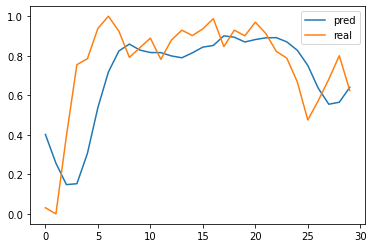

In [106]:
import matplotlib.pyplot as plt
plt.plot(pred,label = "pred")
plt.plot(y_test_set[3],label = "real")
plt.legend()
plt.show()

In [24]:
pred = price_sc.inverse_transform(pred)
real = price_sc.inverse_transform(y_test_set[3].reshape(-1,1))

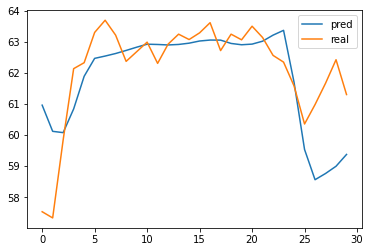

In [25]:
import matplotlib.pyplot as plt
plt.plot(pred,label = "pred")
plt.plot(real,label = "real")
plt.legend()
plt.show()


In [112]:
t = pd.read_parquet("/v3io/projects/stocks-dani/fs/parquet/sets/stocks-latest.parquet")

In [114]:
t

,Datetime,Closes_min_1d,Closes_max_1d,Opens_min_1d,Opens_max_1d,Volumes_min_1h,Volumes_max_1h,Open,High,Low,Close,Volume
Symbol,,,,,,,,,,,,
INTC,2021-04-20 09:30:00-04:00,63.587002,63.587002,63.639999,63.639999,527229,527229,63.639999,63.759998,63.509998,63.587002,527229
INTC,2021-04-20 09:31:00-04:00,63.587002,63.590000,63.580002,63.639999,28939,527229,63.580002,63.650002,63.580002,63.590000,28939
INTC,2021-04-20 09:33:00-04:00,63.439999,63.590000,63.404999,63.639999,28939,527229,63.404999,63.470001,63.340000,63.439999,224186
INTC,2021-04-20 09:34:00-04:00,63.290001,63.590000,63.404999,63.639999,28939,527229,63.455002,63.455002,63.265202,63.290001,79271
INTC,2021-04-20 09:35:00-04:00,63.290001,63.590000,63.290001,63.639999,28939,527229,63.290001,63.560001,63.279999,63.410000,86479
...,...,...,...,...,...,...,...,...,...,...,...,...
INTC,2021-04-28 15:55:00-04:00,57.215000,58.070000,57.215000,58.080002,10216,184144,57.689999,57.689999,57.645000,57.656799,158002
INTC,2021-04-28 15:56:00-04:00,57.215000,58.070000,57.215000,58.080002,10216,185513,57.654999,57.700001,57.639999,57.689999,185513
INTC,2021-04-28 15:57:00-04:00,57.215000,58.070000,57.215000,58.080002,10216,185513,57.689999,57.689999,57.660000,57.669998,129859
